In [1]:
import numpy as np
import os
from astropy.units import Unit
import matplotlib.pyplot as plt

import sys
sys.path.insert(0,'../kl_tools/')

import likelihood
import intensity
import basis
import priors
import utils
import transformation as transform

%matplotlib inline

In [2]:
nx, ny = 30, 30
nmax = 20

true_pars = {
    'g1': 0.25,
    'g2': -0.1,
    'theta_int': np.pi / 3,
    'sini': 0.8,
    'v0': 10.,
    'vcirc': 200,
    'rscale': 5,
}

# additional args needed for prior / likelihood evaluation
halpha = 656.28 # nm
R = 5000.
z = 0.3
pars = {
    'Nx': 30, # pixels
    'Ny': 30, # pixels
    'true_flux': 1e5, # counts
    'true_hlr': 5, # pixels
    'v_unit': Unit('km / s'),
    'r_unit': Unit('kpc'),
    'z': z,
    'spec_resolution': R,
    # 'line_std': 0.17,
    'line_std': halpha * (1.+z) / R, # emission line SED std; nm
    'line_value': 656.28, # emission line SED std; nm
    'line_unit': Unit('nm'),
    'sed_start': 650,
    'sed_end': 660,
    'sed_resolution': 0.025,
    'sed_unit': Unit('nm'),
    'cov_sigma': 4, # pixel counts; dummy value
    'bandpass_throughput': '.2',
    'bandpass_unit': 'nm',
    'bandpass_zp': 30,
    'priors': {
        'g1': priors.GaussPrior(0., 0.1),#, clip_sigmas=2),
        'g2': priors.GaussPrior(0., 0.1),#, clip_sigmas=2),
        'theta_int': priors.UniformPrior(0., np.pi),
        # 'theta_int': priors.UniformPrior(np.pi/3, np.pi),
        'sini': priors.UniformPrior(0., 1.),
        # 'sini': priors.GaussPrior()
        'v0': priors.UniformPrior(0, 20),
        'vcirc': priors.GaussPrior(200, 10, clip_sigmas=2),
        # 'vcirc': priors.UniformPrior(190, 210),
        'rscale': priors.UniformPrior(0, 10),
    },
    'intensity': {
        # For this test, use truth info
        'type': 'inclined_exp',
        'flux': 1e5, # counts
        'hlr': 5, # pixels
        # 'type': 'basis',
        # 'basis_type': 'shapelets',
        # 'basis_kwargs': {
        #     'Nmax': 10,
        #     }
    },
    # 'psf': gs.Gaussian(fwhm=3), # fwhm in pixels
    'use_numba': False,
}

# li, le, dl = 655.5, 657, 0.1
li, le, dl = 655.8, 656.8, 0.1
# li, le, dl = 655.9, 656.8, .1
lambdas = [(l, l+dl) for l in np.arange(li, le, dl)]

Nx, Ny = 30, 30
Nspec = len(lambdas)
shape = (Nx, Ny, Nspec)
print('Setting up test datacube and true Halpha image')
datacube, sed, vmap, true_im = likelihood.setup_likelihood_test(
    true_pars, pars, shape, lambdas
    )

# imap = intensity.build_intensity_map('

Setting up test datacube and true Halpha image


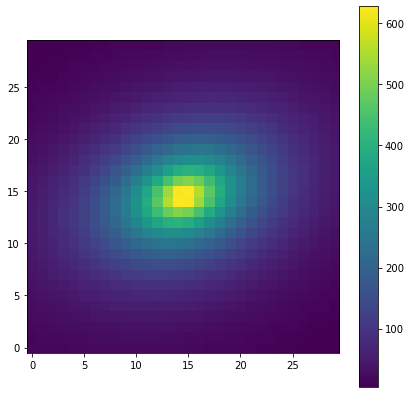

In [3]:
plt.imshow(true_im, origin='lower')
plt.colorbar()
plt.gcf().set_size_inches(7,7)

In [4]:
imap = intensity.BasisIntensityMap(datacube, basis_kwargs={'Nmax':nmax})

TypeError: __init__() missing 1 required positional argument: 'plane'

In [ ]:
basis_im = imap.render()
data_im = np.sum(datacube._data, axis=2)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

titles = ['data', 'model', 'residual']
images = [data_im, basis_im, data_im-basis_im]

for i in range(3):
    ax = axes[i]
    im = images[i]
    ishow = ax.imshow(im, origin='lower')
    plt.colorbar(ishow, ax=ax)
    ax.set_title(titles[i])

In [ ]:
bb = imap.get_basis()
print(vars(basis).keys())

In [ ]:
X, Y = utils.build_map_grid(nx, ny)

In [ ]:
args = [X, Y, *func_args]
bim = func(*args)

In [ ]:
plt.imshow(bim, origin='lower')
plt.colorbar()
plt.title('Basis function 00')

## Transform the coordinates:

In [ ]:
planes = ['disk', 'gal', 'source', 'obs']

s = 12
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(s,s), sharex=True, sharey=True)
for i, plane in enumerate(planes):
#     x, y = transform._disk2gal(true_pars, prev_x, prev_y)
    x, y = transform.transform_coords(X, Y, 'disk', plane, true_pars)
    args = [x, y, *func_args]
    bim = func(*args)

    ax = axes[i//2, i%2]
    mesh = ax.pcolormesh(x, y, bim)
    plt.colorbar(mesh, ax=ax)
    ax.set_title(f'{plane} transform of basis function 00')

In [ ]:
N = 3
func, func_args = bb.get_basis_func(N)

planes = ['disk', 'gal', 'source', 'obs']

# uniform grid for all planes
X, Y = utils.build_map_grid(nx, ny)

s = 12
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(s,s-1), sharex=True, sharey=True)
for i, plane in enumerate(planes):
#     x, y = transform._disk2gal(true_pars, prev_x, prev_y)
    xp, yp = transform.transform_coords(X, Y, plane, 'disk', true_pars)
    args = [xp, yp, *func_args]
    bim = func(*args)

    ax = axes[i//2, i%2]
    mesh = ax.pcolormesh(X, Y, bim)
    plt.colorbar(mesh, ax=ax)
    Nx, Ny = func_args[1], func_args[2]
    ax.set_title(f'{plane} transform of basis function ({Nx},{Ny})')

## Transform the basis funcs:

In [ ]:
planes = ['disk', 'gal', 'source', 'obs']

X, Y = utils.build_map_grid(nx, ny)

s = 12
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(s,s), sharex=True, sharey=True)
for i, plane in enumerate(planes):
#     x, y = transform._disk2gal(true_pars, prev_x, prev_y)
    x, y = transform.transform_coords(X, Y, 'obs', plane, true_pars)
    args = [x, y, *func_args]
    bim = func(*args)

    ax = axes[i//2, i%2]
    mesh = ax.pcolormesh(x, y, bim)
    plt.colorbar(mesh, ax=ax)
    ax.set_title(f'{plane} transform of basis function 00')

In [ ]:
# b_disk = func(*[X, Y, *func_args]).reshape(nx*ny)
# plt.plot(b_disk)
# plt.title('disk')

Xdisk, Ydisk = utils.build_map_grid(5, 5)
Bdisk = func(*[Xdisk, Ydisk, *func_args])
plt.pcolormesh(Xdisk, Ydisk, Bdisk)
plt.gcf().set_size_inches(4,4)
print(Xdisk)

In [ ]:
plt.imshow(Bdisk, origin='lower')